# **PRÁCTICA DEL MÓDULO DE DEEP LEARNING**

El objetivo es predecir el precio de una vivienda de Airbnb utilizando datos de entrada de diferentes fuentes (datos estructurados y no estructurados -imágenes-). 

A continuación se muestra el esquema que se va a seguir para la realización de la práctica.
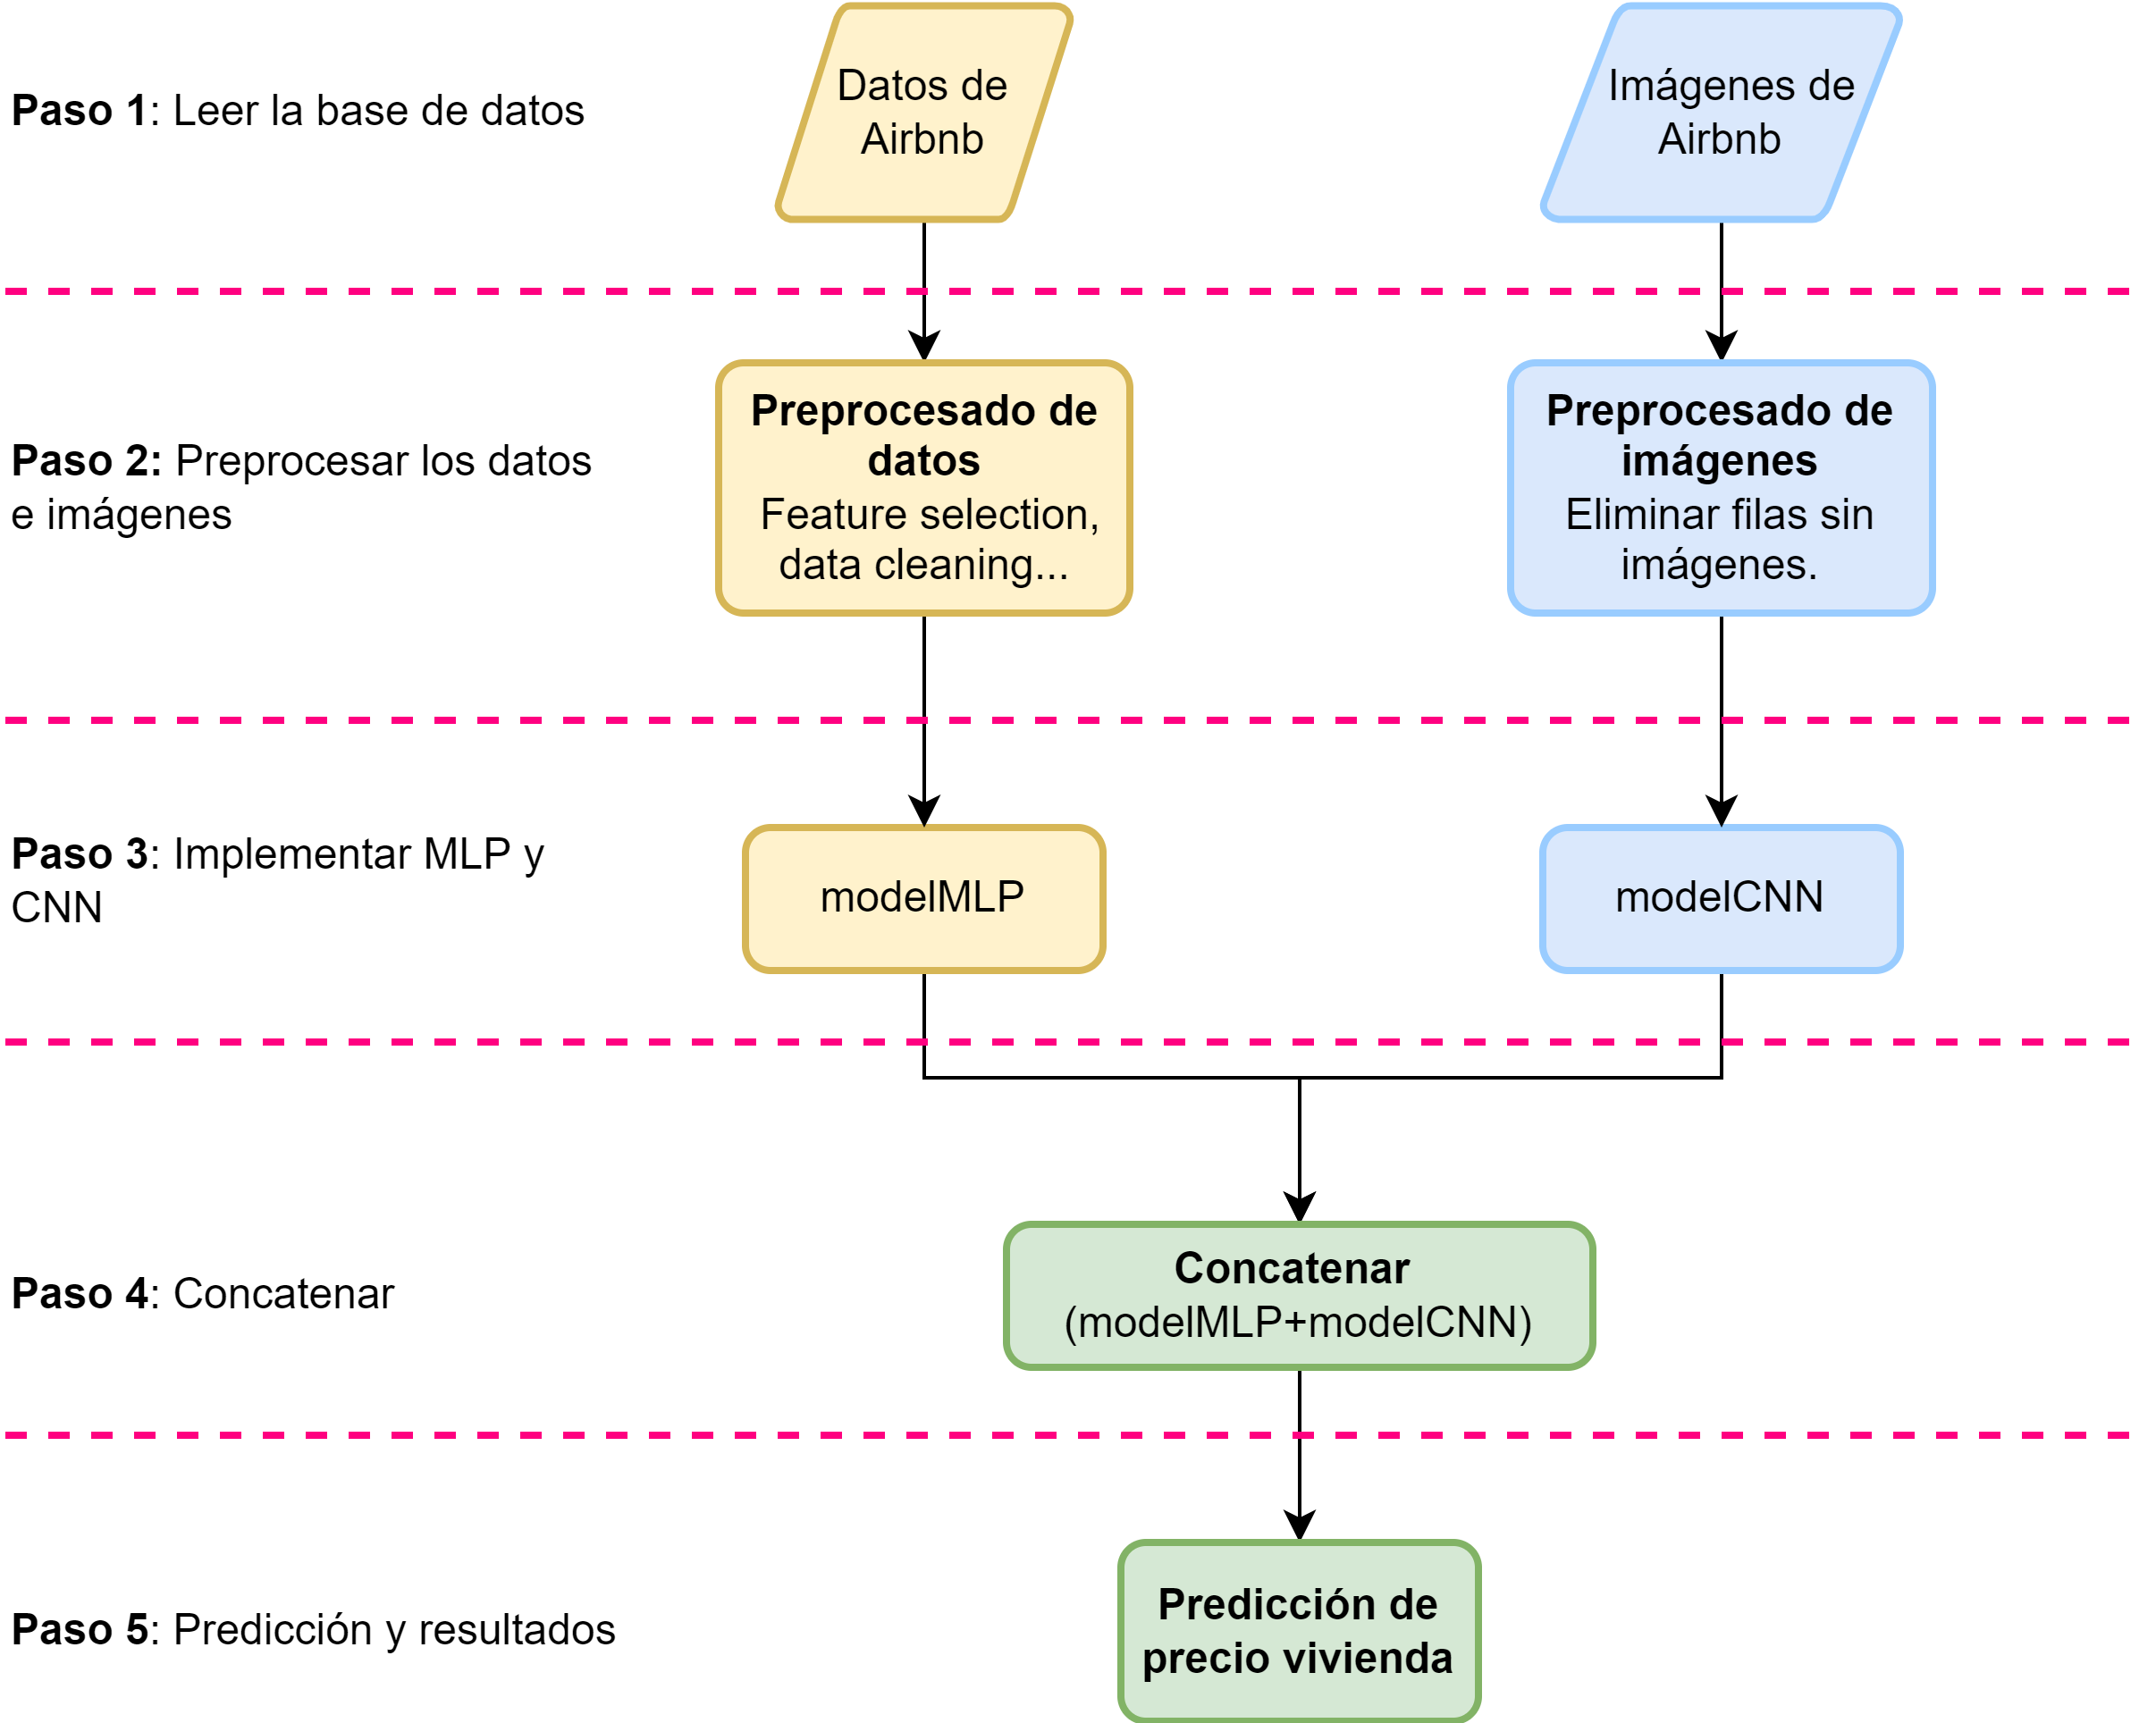

##**NOTA**
He tenido muchísimos problemas para entrenar los modelos (a pesar de utilizar el entorno de ejecución GPU, los modelos de imágenes tardan muchísimo). Por lo que he decidio entrenar con menos épocas, a pesar de que daría mucho mejor entrenándolo con más épocas, pero eso conllevaría a estar más de media hora esperando. Por lo que los resultados mostrados NO son los óptimos.

# **Paso 1: Leer la base de datos de Airbnb**

In [3]:
# Descargamos el dataset
!wget -O "airbnb-listings.csv" "https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B"

--2022-01-30 22:11:51--  https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B
Resolving public.opendatasoft.com (public.opendatasoft.com)... 34.249.199.226, 34.248.20.69
Connecting to public.opendatasoft.com (public.opendatasoft.com)|34.249.199.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/csv]
Saving to: ‘airbnb-listings.csv’

airbnb-listings.csv     [             <=>    ]  54.31M  3.07MB/s    in 24s     

2022-01-30 22:12:19 (2.26 MB/s) - ‘airbnb-listings.csv’ saved [56950929]



In [4]:
# Comprobamos qué hemos descargado
!ls -ll

total 427740
-rw-r--r-- 1 root root  56950929 Jan 30 22:12 airbnb-listings.csv
-rw-r--r-- 1 root root    643578 Jan 30 21:31 data_cleaned.xlsx
-rw-r--r-- 1 root root 380160128 Jan 30 21:39 images_small.npy
-rw-r--r-- 1 root root    159026 Jan 30 22:10 merged.png
drwxr-xr-x 1 root root      4096 Jan  7 14:33 sample_data
-rw-r--r-- 1 root root     70528 Jan 30 21:39 was_loaded_small.npy


In [5]:
# Leemos el archivo importando con PANDAS
import pandas as pd
data = pd.read_csv('airbnb-listings.csv', sep = ';')
data.head(3)

ID  ...                                           Features
0  3150371  ...  Host Has Profile Pic,Host Identity Verified,Is...
1  3378181  ...  Host Has Profile Pic,Host Identity Verified,Is...
2  2070750  ...  Host Has Profile Pic,Host Identity Verified,Is...

[3 rows x 89 columns]


Comprobamos el tamaño del dataset: 14001 filas y 89 columnas



In [6]:
# Let's check the shape of our dataset. Rows and columns (variables) 
data.shape

(14001, 89)

Las columnas que contienen imágenes son: Thumbnail Url, Medium Url, XL Picture Url. Se utilizará la columna `XL Picture Url`, al tener una mayor resolución de imagen. 

In [7]:
# Variable names
data.columns

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Month

Extraemos todas las imágenes en un array. Extraemos las imágenes de la columna 'XL Picture Url' por tener mejor calidad de imagen.

# **Paso 2: Preprocesado/limpieza de datos**
Comprender los datos (Análisis Exploratorio)

### **¿Faltan datos? ¿En qué columnas?**

Como era de esperar, la columna XL picture no tiene ningún missing value ya que han sido eliminados en el paso anterior. Elimino todas aquellas columnas que contienen una gran cantidad de missing records. 

In [8]:
# Número de Nan por atributo
data_nan = data.isna().sum()
# Total Nan en el dataset
total_nan = data_nan.sum()
missingdata = pd.DataFrame(0, index = range(0,2), columns = data.columns)
missingdata.shape
for i in range(0,len(data_nan)):
    missingdata.iloc[0,i] =  data_nan[i]
    missingdata.iloc[1,i] =  (data_nan[i]/len(data))*100
    
# Imprimir el número total de missing values
print("Total Nan: ", total_nan)

# Imprimir los missing values de cada feature
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(data_nan)

Total Nan:  203193
ID                                    0
Listing Url                           0
Scrape ID                             0
Last Scraped                          0
Name                                  0
Summary                             550
Space                              3695
Description                           6
Experiences Offered                   0
Neighborhood Overview              5371
Notes                              8713
Transit                            5449
Access                             6139
Interaction                        6212
House Rules                        4876
Thumbnail Url                      2712
Medium Url                         2712
Picture Url                          29
XL Picture Url                     2712
Host ID                               0
Host URL                              0
Host Name                             3
Host Since                            3
Host Location                        42
Host About           

In [9]:
# La primera fila indica el número total de missing data. 
# La segunda fila indica el PORCENTAJE total de missing data de cada atributo.
missingdata


ID  Listing Url  Scrape ID  ...  Reviews per Month  Geolocation  Features
0  0.0          0.0        0.0  ...        3007.000000          0.0       0.0
1  0.0          0.0        0.0  ...          21.477037          0.0       0.0

[2 rows x 89 columns]

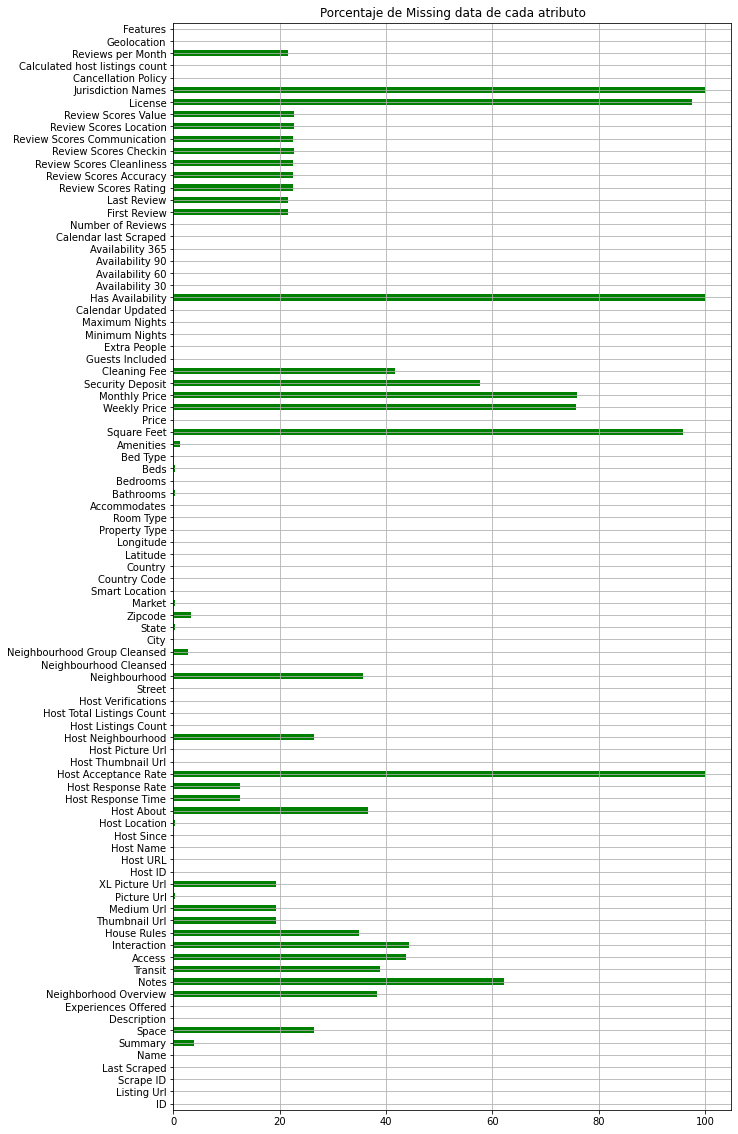

In [10]:
missingdata.iloc[1,:].plot(kind="barh", figsize = (10,20), grid = True, color = "Green", title = "Porcentaje de Missing data de cada atributo")

Se ha decidido eliminar todos los atributos con más de un 30% de missing data. EL motivo es que no se puede trabajar con missing values en los algoritmos de machine learning. Tampoco es recomendable imputar valores a un grán número de datos, ya que a la hora de hacer la predicción, es mejor no imputar, ya que ese valor no es el verdadero y puede generar ruido/bias en nuestro modelo.

In [11]:
data_clean = data.copy()
deleted_columns = []
for i in range(0,len(data.columns)):
    if missingdata.iloc[1,i] > 30:
        colname = data.columns[i]
        deleted_columns.append(colname)
        data_clean.drop(colname, inplace=True, axis=1)
print(data_clean.shape)

(14001, 72)


In [12]:
data_clean.shape

(14001, 72)

Se han **eliminado 17 atributos por su alto porcentaje de celdas vacías**

In [13]:
# Atributos eliminados por su alto porcentage en missing values

deleted_columns

['Neighborhood Overview',
 'Notes',
 'Transit',
 'Access',
 'Interaction',
 'House Rules',
 'Host About',
 'Host Acceptance Rate',
 'Neighbourhood',
 'Square Feet',
 'Weekly Price',
 'Monthly Price',
 'Security Deposit',
 'Cleaning Fee',
 'Has Availability',
 'License',
 'Jurisdiction Names']

## **Elimino todas las columnas que contengan gran cantidad de texto, , direcciones web y fechas de scrapeado.** 

Para entrenar un modelo de machine learning
es necesario utilizar valores numéricos, no texto. Si se quisiera utilizar los atributos que contienen cierta cantidad de texto, 
se debería de implementar un algoritmo que extraiga el "sentyment analysis" del texto y utilizar eso como posible variable de entrada, aplicando la codificación de estos "sentimientos", pero eso se encuentra out of the scope de este proyecto. 

Hay ciertas variables que por sentido común no tienen influencia en el precio, como son 'Last Scraped', 'Name', 'Host Name'. Además 'Country Code' no procede ya que todos los apartamentos están situados en el mismo país. 'State' hace referencia a lo mismo, es redundante. Por lo tanto se eliminan también ambas features.

In [14]:
text_columns = ['Last Scraped', 'Name', 'Space', 'Listing Url', 'Summary', 'Description', 'Experiences Offered', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host URL', 'Host Name', 'Host Neighbourhood', 'Host Location', 'Host Since', 'Host Thumbnail Url', 'Host Picture Url', 'Host Verifications', 'Street', 'Amenities', 'Neighbourhood Cleansed','First Review', 'Market', 'Smart Location', 'Country Code', 'State', 'Last Review', 'Geolocation','Zipcode', 'Calendar last Scraped', 'Calendar Updated', 'Features']

for i in range(0,len(text_columns)):
    data_clean.drop(text_columns[i], inplace=True, axis=1)

## **Visualizar los datos**

Una manera visual de entender los datos de entrada: Matriz de correlación

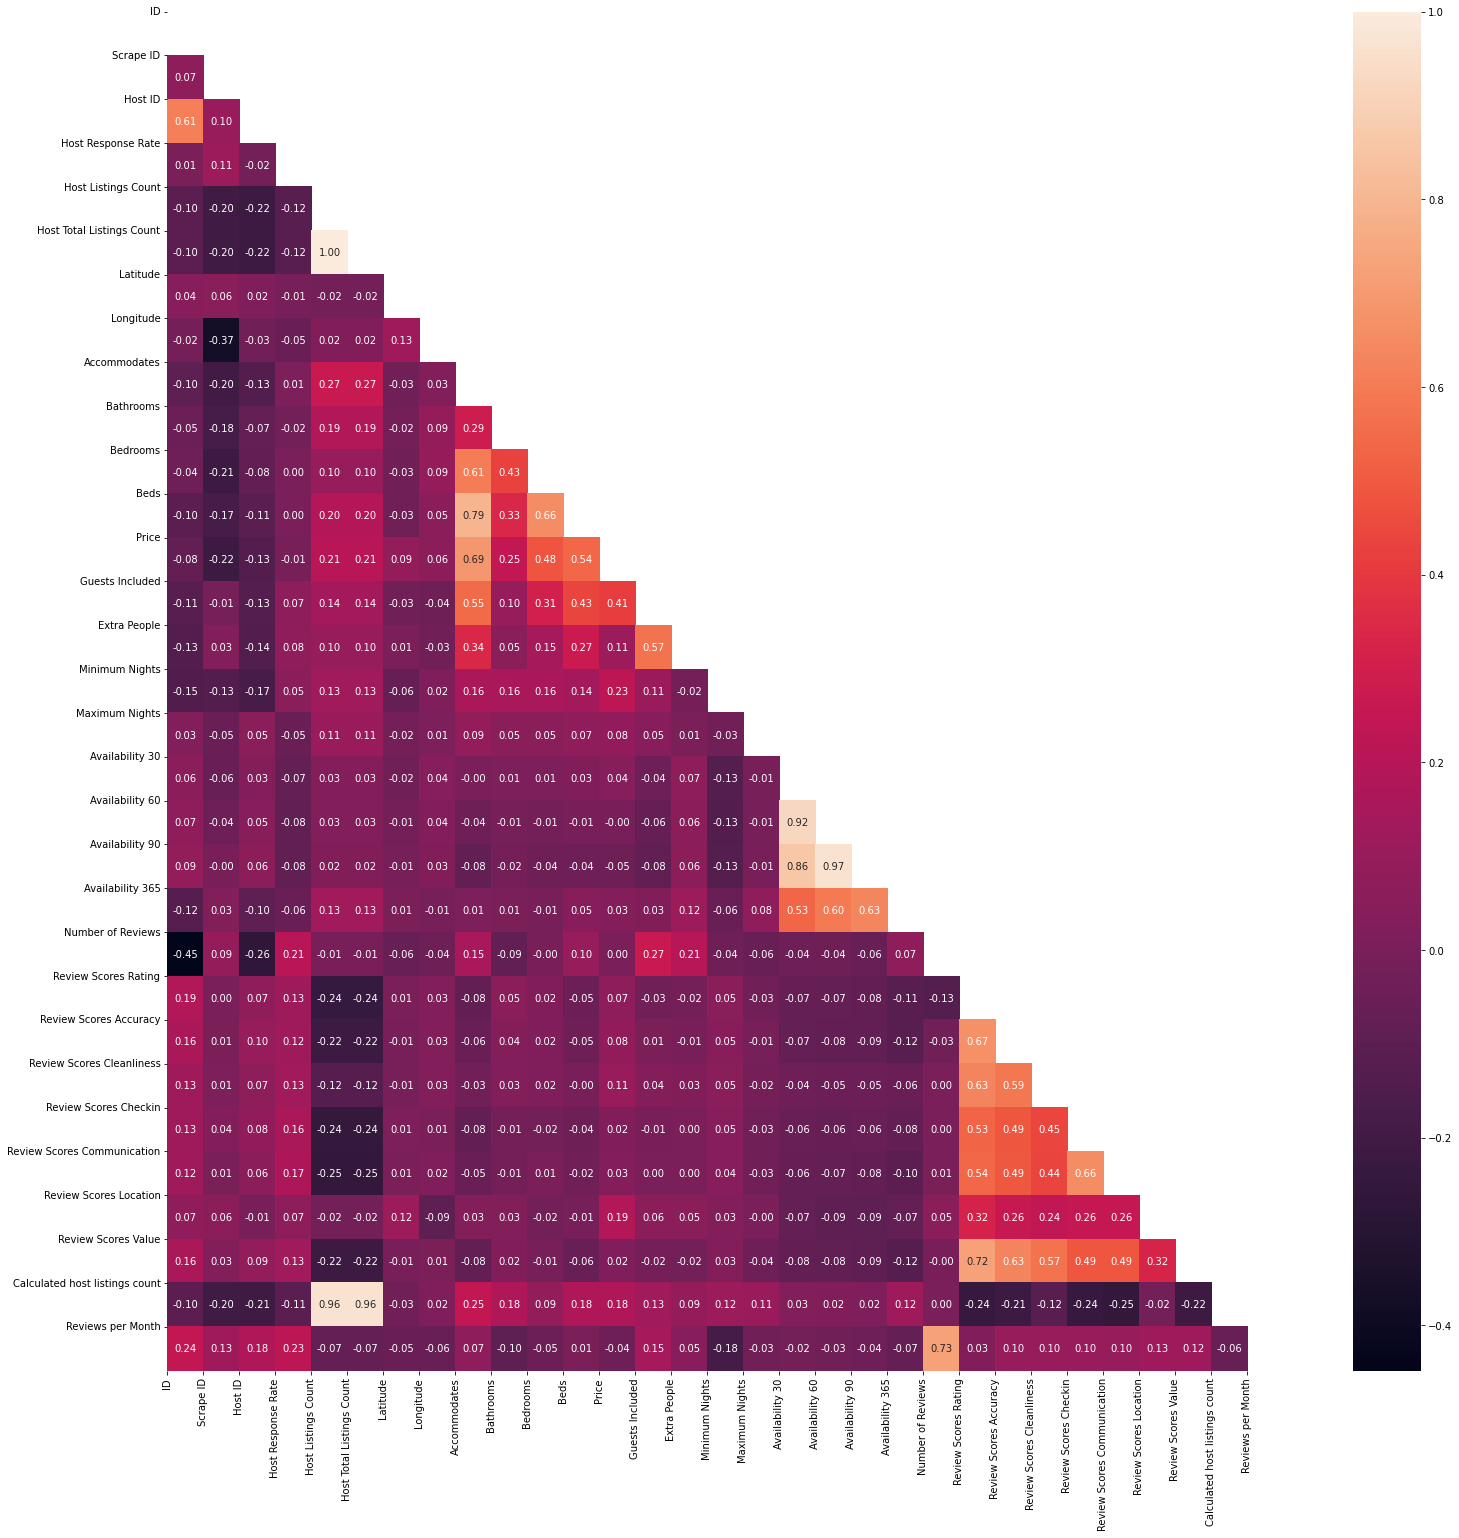

In [15]:
# MATRIZ DE CORRELACIÓN
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Cálculo de coeficientes de correlación
corr = data_clean.corr(method='spearman') 

# Quitar valores repetidos
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
  
f, ax = plt.subplots(figsize=(25, 25))
#Generar Heat Map,
sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
    # xticks
plt.xticks(range(len(corr.columns)), corr.columns);
    # yticks
plt.yticks(range(len(corr.columns)), corr.columns)
    # plot
plt.show()

Mirando la matriz de correlación, se pueden eliminar atributos que no guardan correlación con la variable target **precio**. 
Aquellos atributos con una correlación cercana a 0 serán eliminados. 

Las variables **"Host Listings Count" y "Host Total Listings Count" están altamente correladas con "Calculated host listings count", por lo que elimino una de las dos, ya que la información que aportan es repetida.**

Se eliminan además otras variables categóricas que se ha demostrado en el módulo de deep learning que no aportan informacióne extra para predecir el precio. 

Se han **eliminado 28 atributos**

In [16]:
no_correlated_columns = ['ID', 'Scrape ID', 'Host ID', 'Host Response Rate', 'Host Listings Count', 'Host Total Listings Count', 'Calculated host listings count', 'Latitude', 'Longitude', 'Maximum Nights', 'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365', 'Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Value', 'Reviews per Month', 'Bed Type', 
                         'Neighbourhood Group Cleansed', 'City', 'Country', 'Property Type', 'Host Response Time']

for i in range(0,len(no_correlated_columns)):
    data_clean = data_clean.drop(no_correlated_columns[i], axis=1)

### **Analizo ciertas variables categóricas interesantes para la predicción del precio.**

**ROOM TYPE**

Entire home/apt    8523
Private room       5285
Shared room         193
Name: Room Type, dtype: int64


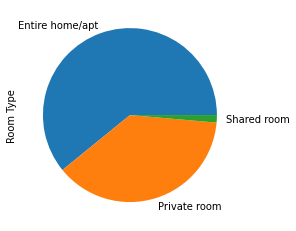

In [17]:
# Comprobar si las etiquetas están desvalanceadas
room_clases = data_clean["Room Type"].value_counts()
print(room_clases)

# Gráfico del balance de clases
room_clases.plot.pie()

In [18]:
dummy = pd.get_dummies(data_clean["Room Type"])
data_clean = pd.concat([data_clean,dummy],axis=1).drop(['Room Type'],axis=1)

**CANCELLATION POLICY**

strict             5474
flexible           4428
moderate           4048
super_strict_60      32
super_strict_30      19
Name: Cancellation Policy, dtype: int64


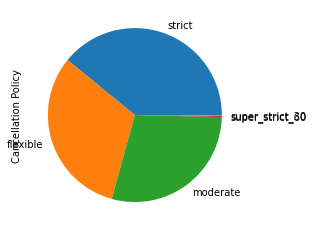

In [19]:
# Comprobar si las etiquetas están desvalanceadas
cancelation_clases = data["Cancellation Policy"].value_counts()
print(cancelation_clases)

# Gráfico del balance de clases
cancelation_clases.plot.pie()

In [20]:
dummy = pd.get_dummies(data_clean["Cancellation Policy"])
data_clean = pd.concat([data_clean,dummy],axis=1).drop(['Cancellation Policy'],axis=1)
data_clean.drop(["super_strict_30", "super_strict_60"], axis=1, inplace=True)


Echamos un vistazo a como ha quedado el data set limpio

In [21]:
data_clean[:5]



Thumbnail Url  ...  strict
0  https://a0.muscache.com/im/pictures/40713802/3...  ...       0
1  https://a0.muscache.com/im/pictures/44239584/c...  ...       1
2  https://a0.muscache.com/im/pictures/84378550/f...  ...       0
3  https://a0.muscache.com/im/pictures/be441d1f-4...  ...       1
4  https://a0.muscache.com/im/pictures/c232f016-f...  ...       0

[5 rows x 16 columns]

### **Correlación de features seleccionadas**

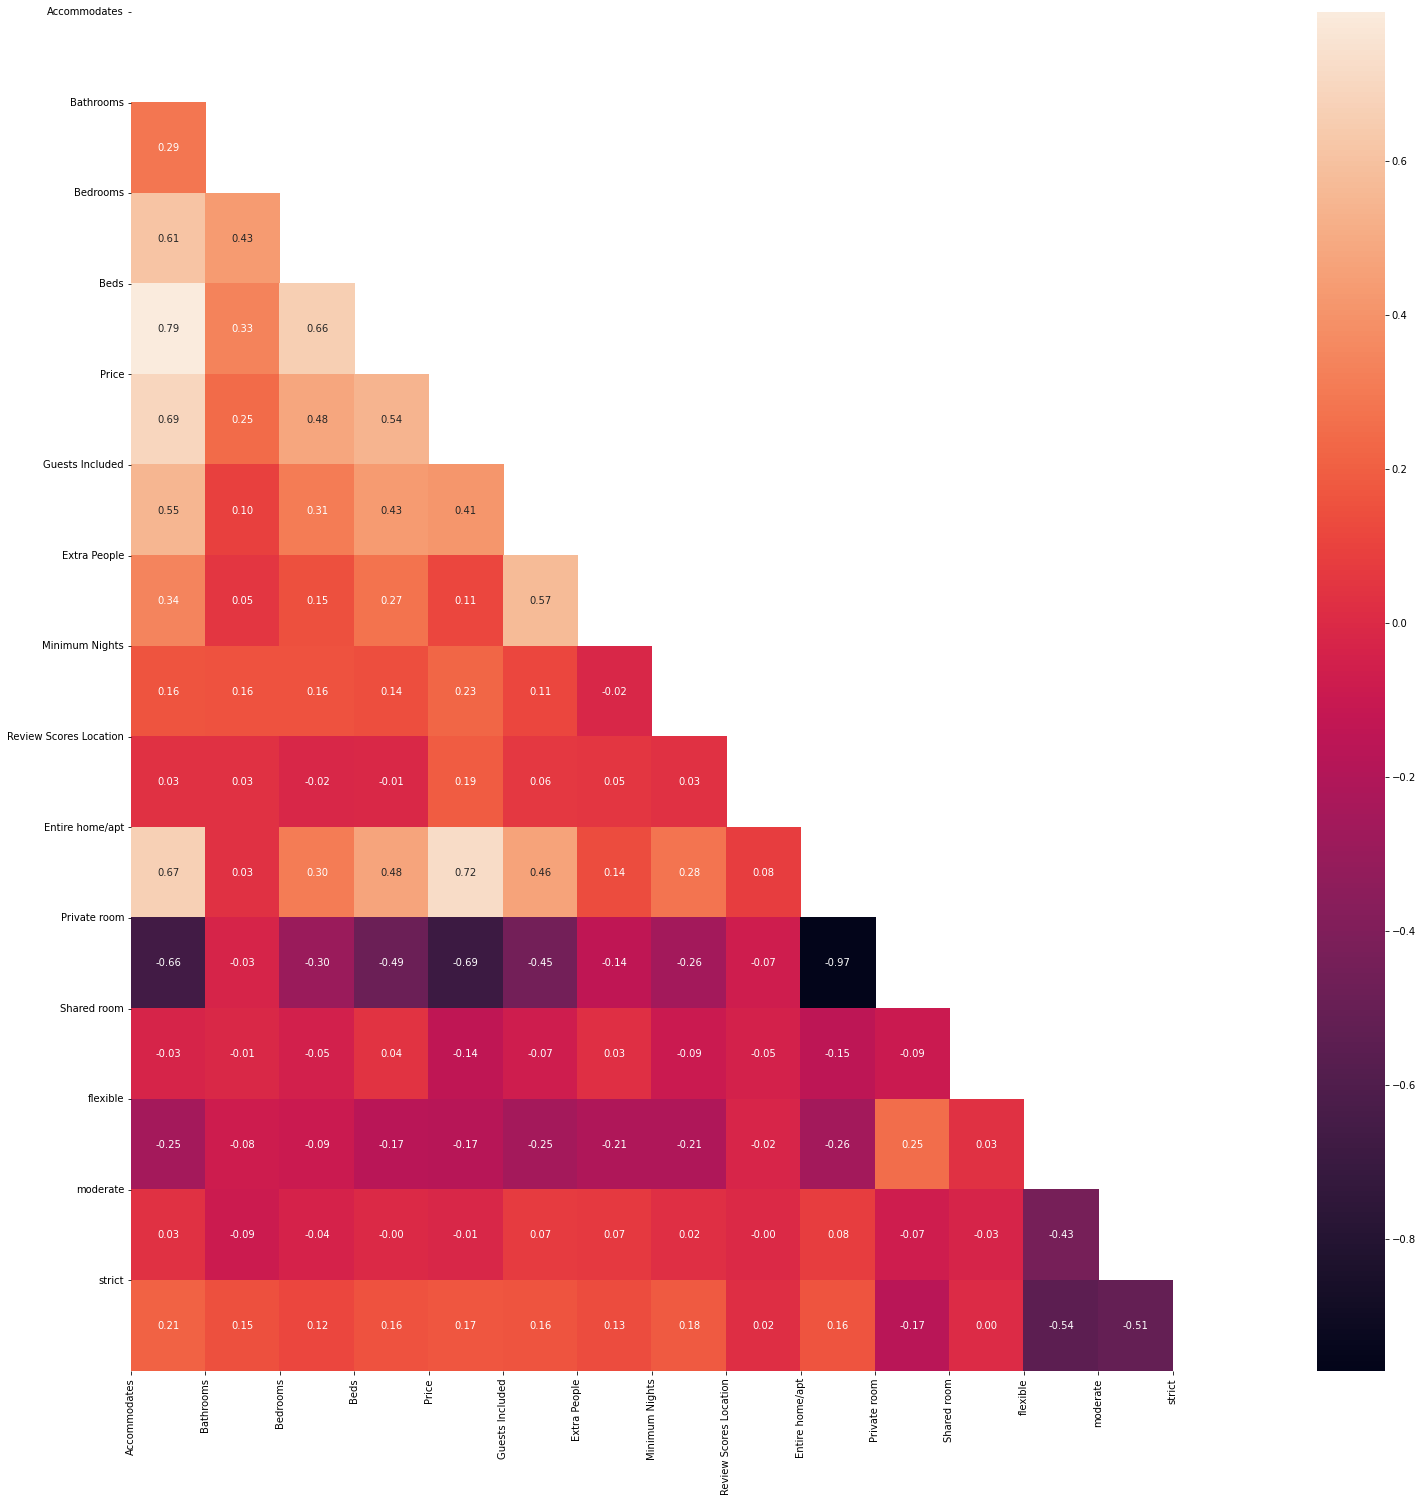

In [22]:
# Cálculo de coeficientes de correlación
corr = data_clean.corr(method='spearman') 

# Quitar valores repetidos
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
  
f, ax = plt.subplots(figsize=(25, 25))
#Generar Heat Map,
sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
    # xticks
plt.xticks(range(len(corr.columns)), corr.columns);
    # yticks
plt.yticks(range(len(corr.columns)), corr.columns)
    # plot
plt.show()

Nos aseguramos de que no hay ningín missing value:


In [23]:
# Número de Nan por atributo
data_clean_nan = data_clean.isna().sum()

# Imprimir los missing values de cada feature
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(data_clean_nan)

print(data_clean.shape)

Thumbnail Url             2712
Accommodates                 0
Bathrooms                   52
Bedrooms                    24
Beds                        49
Price                       11
Guests Included              0
Extra People                 0
Minimum Nights               0
Review Scores Location    3171
Entire home/apt              0
Private room                 0
Shared room                  0
flexible                     0
moderate                     0
strict                       0
dtype: int64
(14001, 16)


In [24]:
# Elimino las filas que contienen algún Nan
data_clean.dropna(axis=0, inplace=True)
print(data_clean.shape)

(8800, 16)


In [25]:
data_clean_nan = data_clean.isna().sum()

# Imprimir los missing values de cada feature
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(data_clean_nan)

Thumbnail Url             0
Accommodates              0
Bathrooms                 0
Bedrooms                  0
Beds                      0
Price                     0
Guests Included           0
Extra People              0
Minimum Nights            0
Review Scores Location    0
Entire home/apt           0
Private room              0
Shared room               0
flexible                  0
moderate                  0
strict                    0
dtype: int64


In [26]:
print(data_clean.shape)
print(data_clean.columns)

(8800, 16)
Index(['Thumbnail Url', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds',
       'Price', 'Guests Included', 'Extra People', 'Minimum Nights',
       'Review Scores Location', 'Entire home/apt', 'Private room',
       'Shared room', 'flexible', 'moderate', 'strict'],
      dtype='object')


In [27]:
# Guardo el dataset procesado y limpio
data_clean.to_excel('data_cleaned.xlsx', index=False)


## **Podemos cargar el dataset limpio directamente desde AQUÍ**
`data_cleaned.xlsx`

In [2]:
import pandas as pd
data_clean = pd.read_excel('data_cleaned.xlsx')

Separo las imágenes de los datos numéricos. 

In [28]:
# Reseteo el index
data_clean.reset_index(drop=True, inplace=True)
data_clean

Thumbnail Url  ...  strict
0     https://a0.muscache.com/im/pictures/40713802/3...  ...       0
1     https://a0.muscache.com/im/pictures/44239584/c...  ...       1
2     https://a0.muscache.com/im/pictures/84378550/f...  ...       0
3     https://a0.muscache.com/im/pictures/be441d1f-4...  ...       1
4     https://a0.muscache.com/im/pictures/c232f016-f...  ...       0
...                                                 ...  ...     ...
8795  https://a0.muscache.com/im/pictures/21389221/0...  ...       1
8796  https://a0.muscache.com/im/pictures/15a91f13-8...  ...       1
8797  https://a0.muscache.com/im/pictures/38469453/8...  ...       0
8798  https://a0.muscache.com/im/pictures/23814310/d...  ...       0
8799  https://a0.muscache.com/im/pictures/46287719/5...  ...       0

[8800 rows x 16 columns]

### Dividimos los datos de entrada `IMAGEN (data_modelCNN)` vs `DATA(data_modelMLP)`

In [29]:
data_modelCNN = data_clean[["Thumbnail Url", "Price"]]
data_modelMLP = data_clean.drop(["Thumbnail Url"], axis=1)


## **Predicción de precio utilizando imágenes de AIRBNB: modelCNN**




In [30]:
# Dataset con los datos de imágenes
data_modelCNN[:5]
data_modelCNN.shape

(8800, 2)

### **Cargamos y guardamos las imágenes para procesar** 
(este paso se puede saltar, ya que se han guardado anteriormente los archivos `images_small.npy` y `was_loaded_small.npy`

In [7]:
# Let's create a list with image url and index
images_paths = []
for i, img_url in enumerate(data_modelCNN['Thumbnail Url']):
  images_paths.append([i, img_url])

# A more simple and pythonist way
# images_paths = [[i, img_url] for i, img_url in enumerate(data['Thumbnail Url'])]

In [8]:
# Let's see what we build
print(images_paths[:2])
print(len(images_paths))

[[0, 'https://a0.muscache.com/im/pictures/d1a2212d-c13b-45ec-b1f7-2f0b6dc53137.jpg?aki_policy=small'], [1, 'https://a0.muscache.com/im/pictures/3eb59287-8b7c-42ff-95c7-8d00cbfd4c55.jpg?aki_policy=small']]
8800


In [9]:
import imageio as io
import cv2

# # This function downloads the images and returns them with the index where to save them

def get_image(data_url, target_size=(120, 120)):
     idx, url = data_url
     try:
         img = io.imread(url)
         # Some images may be in black & white. I convert to to RGB as otherwise it generates error
         if img.ndim < 3:
             img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
         img = cv2.resize(img, dsize=target_size)
         return img, idx
     except IOError as err:
         return (None, idx)

In [10]:
import imageio as io
import cv2
import numpy as np
from numpy import moveaxis
import PIL.Image

# This function downloads the images and returns them with the index where to save them

def get_image(data_url, target_size=(120, 120)):
    idx, url = data_url
    try:
        img = io.imread(url)

        # If channels info is in first place, move to last position
        if (img.shape[0] < img.shape[1] ) and (img.shape[0] < img.shape[2]):
          img = moveaxis(img, 0, 2)

        # In case any image is RGBA, take onloy RGB channels
        img = img[...,:3]

        # Some images may be in black & white. I convert to to RGB as otherwise it generates error
        if img.ndim < 3:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, dsize=target_size)
        return img, idx
        
    except IOError as err:
        return (None, idx)

In [11]:
import numpy as np

# Tensor to save the images
loaded_images = np.zeros((len(images_paths), 120, 120, 3), dtype=np.uint8)

# Tensor to check whihc images were not saved
was_loaded = np.zeros(len(images_paths))

In [12]:
import concurrent
from tqdm import tqdm

# Creating pool to load images. By default, it uses as much cores as your machine has

with concurrent.futures.ProcessPoolExecutor() as executor:


    for (img, idx) in tqdm(executor.map(get_image, images_paths), total=len(images_paths)):

        # Loading the images

        if img is not None:
            loaded_images[idx] = img
            was_loaded[idx] = 1
        else:
            was_loaded[idx] = 0

print('Finished!')
print(f'Number of images loaded: {sum(was_loaded)}/{len(images_paths)}')

100%|██████████| 8800/8800 [06:34<00:00, 22.31it/s]

Finished!
Number of images loaded: 8774.0/8800


In [13]:
# Saving images. I'd recommend to save this to not repeat this process
np.save('images_small.npy', loaded_images)
np.save('was_loaded_small.npy', was_loaded)

### **Cargamos las imágenes que están guardadas en el formato .npy**


In [31]:
import numpy as np

# Load images already saved
loaded_images = np.load('images_small.npy')

# Tensor to check whihc images were not saved
was_loaded = np.load('was_loaded_small.npy')

In [4]:
print(loaded_images.shape)

(8800, 120, 120, 3)


Comprobamos como se ven las imágenes guardadas y su precio correspondiente

Precio =  150


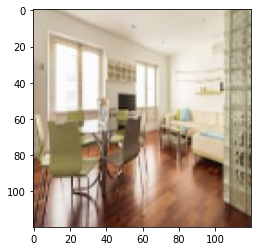

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Example of a picture
index = 5
plt.imshow(loaded_images[index])
print ("Precio = ", data_modelCNN.loc[index, "Price"])

Separamos en dataset en `Train` y `Test`

In [32]:
# Atributos X (features); etiquetas y (target)
y = data_modelCNN[["Price"]]
X = loaded_images
X.shape

(8800, 120, 120, 3)

In [33]:
from sklearn.model_selection import train_test_split

test_size = 0.2  # porcentaje de los datos de entrada que utilizaré para validar el modelo

# Divido los datos en datos de entreno, validación y prueba
X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0,
                                                    shuffle=True)


In [11]:
X_train_cnn[:3]

array([[[[ 28,  24,  15],
         [ 28,  24,  15],
         [ 28,  23,  17],
         ...,
         [ 19,   9,   7],
         [ 40,  31,  26],
         [ 41,  31,  23]],

        [[ 28,  24,  15],
         [ 28,  24,  15],
         [ 28,  23,  17],
         ...,
         [ 19,  11,   8],
         [ 33,  24,  19],
         [ 40,  30,  22]],

        [[ 29,  25,  16],
         [ 29,  24,  16],
         [ 29,  24,  18],
         ...,
         [ 21,  13,  10],
         [ 23,  15,   9],
         [ 38,  29,  21]],

        ...,

        [[205, 192, 174],
         [190, 177, 160],
         [193, 177, 162],
         ...,
         [ 35,  28,  20],
         [ 39,  32,  24],
         [ 38,  31,  23]],

        [[210, 196, 175],
         [190, 176, 156],
         [191, 175, 157],
         ...,
         [ 45,  37,  28],
         [ 45,  36,  28],
         [ 42,  34,  25]],

        [[219, 204, 181],
         [195, 179, 156],
         [192, 175, 155],
         ...,
         [ 68,  59,  50],
        

Evaluamos la forma que tienen nuestros datos. 

Dividimos las imágenes entre 255 para normalizarlas.

In [34]:
X_train_cnn = X_train_cnn/255.
X_test_cnn = X_test_cnn/255.
# Y_train = convert_to_one_hot(Y_train_orig, 6).T
# Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train_cnn.shape[0]))
print ("number of test examples = " + str(X_test_cnn.shape[0]))
print ("X_train_cnn shape: " + str(X_train_cnn.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test_cnn shape: " + str(X_test_cnn.shape))
print ("Y_test shape: " + str(y_test.shape))
conv_layers = {}

number of training examples = 7040
number of test examples = 1760
X_train_cnn shape: (7040, 120, 120, 3)
Y_train shape: (7040, 1)
X_test_cnn shape: (1760, 120, 120, 3)
Y_test shape: (1760, 1)


Implementamos una CNN secilla para comenzar

In [13]:
# import the necessary packages
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Dense, Flatten, Input
import tensorflow as tf

def create_cnn1(img_shape, filters=(64, 32, 64)):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = img_shape
	chanDim = -1

	# define the model input
	inputs = Input(shape=inputShape)
	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input appropriately
		if i == 0:
			x = inputs
		# CONV => RELU => BN => POOL
		x = Conv2D(f, (1, 1), padding="same")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = Activation("relu")(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
	
	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Activation("relu")(x)
	x = Dropout(0.8)(x)
	# apply another FC layer, this one to match the number of nodes coming out of the MLP
	x = Dense(4)(x)
	x = Activation("relu")(x)
	# check to see if the regression node should be added
	x = Dense(1, activation="linear")(x)
	# construct the CNN
	model = Model(inputs, x)
	# return the CNN
	return model


def create_cnn2(img_shape):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = img_shape
	chanDim = -1

	# define the model input
	inputs = Input(shape=inputShape)
	x1 = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', name="conv1_img")(inputs)
	x1 = tf.keras.layers.MaxPooling2D(name="mxp1_img")(x1)
	x1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', name="conv2_img")(x1)
	x1 = tf.keras.layers.MaxPooling2D(name="mxp2_img")(x1)
	x1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', name="conv3_img")(x1)
	x1 = tf.keras.layers.MaxPooling2D(name="mxp3_img")(x1)
	x1 = tf.keras.layers.Flatten(name="flatten_img")(x1)
	x1= Dense(8, activation='relu')(x1)
	x1 = Dense(1, activation="linear")(x1)
	model = Model(inputs, x1)
	return model

In [14]:
# create our Convolutional Neural Network and then compile the model using mean absolute percentage error as our loss, implying that we
# seek to minimize the absolute percentage difference between our price *predictions* and the *actual prices*
img_shape = (120, 120, 3)
model1cnn = create_cnn1(img_shape)
model2cnn = create_cnn2(img_shape)

In [15]:
from tensorflow.keras.optimizers import Adam

model1cnn.compile(loss="mean_absolute_percentage_error",
              optimizer=Adam(),
              metrics=["mean_absolute_percentage_error"])

model1cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 64)      256       
                                                                 
 batch_normalization (BatchN  (None, 120, 120, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 120, 120, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        2080  

In [16]:
history1cnn = model1cnn.fit(X_train_cnn,
          y_train,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_data=(X_test_cnn, y_test))

Epoch 1/10
110/110 [==============================] - 17s 58ms/step - loss: 93.8142 - mean_absolute_percentage_error: 93.8142 - val_loss: 87.2108 - val_mean_absolute_percentage_error: 87.2108
Epoch 2/10
110/110 [==============================] - 5s 50ms/step - loss: 85.5877 - mean_absolute_percentage_error: 85.5877 - val_loss: 65.7798 - val_mean_absolute_percentage_error: 65.7798
Epoch 3/10
110/110 [==============================] - 5s 50ms/step - loss: 76.8663 - mean_absolute_percentage_error: 76.8663 - val_loss: 50.2613 - val_mean_absolute_percentage_error: 50.2613
Epoch 4/10
110/110 [==============================] - 5s 50ms/step - loss: 68.7246 - mean_absolute_percentage_error: 68.7246 - val_loss: 48.4962 - val_mean_absolute_percentage_error: 48.4962
Epoch 5/10
110/110 [==============================] - 6s 50ms/step - loss: 63.4103 - mean_absolute_percentage_error: 63.4103 - val_loss: 44.6417 - val_mean_absolute_percentage_error: 44.6417
Epoch 6/10
110/110 [========================

In [17]:
from tensorflow.keras.optimizers import Adam

model2cnn.compile(loss="mean_absolute_percentage_error",
              optimizer=Adam(),
              metrics=["mean_absolute_percentage_error"])

model2cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv1_img (Conv2D)          (None, 120, 120, 16)      448       
                                                                 
 mxp1_img (MaxPooling2D)     (None, 60, 60, 16)        0         
                                                                 
 conv2_img (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 mxp2_img (MaxPooling2D)     (None, 30, 30, 32)        0         
                                                                 
 conv3_img (Conv2D)          (None, 30, 30, 64)        18496     
                                                                 
 mxp3_img (MaxPooling2D)     (None, 15, 15, 64)        0   

In [18]:
history2cnn = model2cnn.fit(X_train_cnn,
          y_train,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_data=(X_test_cnn, y_test))

Epoch 1/10
110/110 [==============================] - 5s 31ms/step - loss: 49.3238 - mean_absolute_percentage_error: 49.3238 - val_loss: 44.5629 - val_mean_absolute_percentage_error: 44.5629
Epoch 2/10
110/110 [==============================] - 2s 20ms/step - loss: 46.1155 - mean_absolute_percentage_error: 46.1155 - val_loss: 46.0367 - val_mean_absolute_percentage_error: 46.0367
Epoch 3/10
110/110 [==============================] - 2s 20ms/step - loss: 45.9794 - mean_absolute_percentage_error: 45.9794 - val_loss: 44.8826 - val_mean_absolute_percentage_error: 44.8826
Epoch 4/10
110/110 [==============================] - 2s 20ms/step - loss: 45.3509 - mean_absolute_percentage_error: 45.3509 - val_loss: 44.3735 - val_mean_absolute_percentage_error: 44.3735
Epoch 5/10
110/110 [==============================] - 2s 20ms/step - loss: 44.6079 - mean_absolute_percentage_error: 44.6079 - val_loss: 43.6158 - val_mean_absolute_percentage_error: 43.6158
Epoch 6/10
110/110 [=========================

### Se muestran los resultados del entreno de los dos modelos de CNN. 

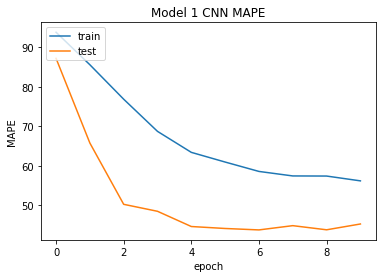

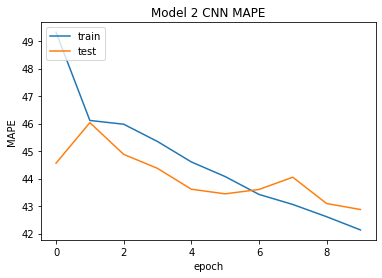

In [19]:
# summarize history for accuracy
plt.plot(history1cnn.history["mean_absolute_percentage_error"])
plt.plot(history1cnn.history['val_mean_absolute_percentage_error'])
plt.title('Model 1 CNN MAPE')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history2cnn.history["mean_absolute_percentage_error"])
plt.plot(history2cnn.history['val_mean_absolute_percentage_error'])
plt.title('Model 2 CNN MAPE')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Predicción de precio utilizando datos de AIRBNB: modelMLP**

Estos son los datos que se utilizarán


In [12]:
data_modelMLP[:5]

Accommodates  Bathrooms  Bedrooms  ...  flexible  moderate  strict
0             2        1.0         0  ...         0         1       0
1             4        1.0         1  ...         0         0       1
2             4        1.5         1  ...         0         1       0
3             5        1.0         2  ...         0         0       1
4             2        1.5         1  ...         0         1       0

[5 rows x 15 columns]

Dividimos los datos en FEATURES y TARGET

In [35]:

# Atributos X (features); etiquetas y (target)
y = data_modelMLP[["Price"]]
X = data_modelMLP.drop(["Price"], axis=1)

**Escalar datos**

Utilizo el MinMaxScaler, utilizando un rango de [0,1]. 

In [36]:
from sklearn.preprocessing import MinMaxScaler


# performin min-max scaling each continuous feature column to the range [0, 1]

scaler = MinMaxScaler(feature_range=(0, 1))
sc_data = scaler.fit_transform(X)
X = pd.DataFrame(sc_data, columns=[X.columns])
X

Accommodates Bathrooms Bedrooms  ... flexible moderate strict
0        0.066667     0.125      0.1  ...      1.0      0.0    0.0
1        0.066667     0.125      0.1  ...      0.0      0.0    1.0
2        0.066667     0.125      0.1  ...      1.0      0.0    0.0
3        0.200000     0.125      0.1  ...      0.0      0.0    1.0
4        0.466667     0.375      0.3  ...      0.0      1.0    0.0
...           ...       ...      ...  ...      ...      ...    ...
8795     0.333333     0.125      0.2  ...      0.0      0.0    1.0
8796     0.333333     0.125      0.6  ...      0.0      0.0    1.0
8797     0.200000     0.125      0.1  ...      0.0      1.0    0.0
8798     0.266667     0.125      0.3  ...      0.0      1.0    0.0
8799     0.200000     0.125      0.2  ...      0.0      1.0    0.0

[8800 rows x 14 columns]

**Dividir los datos**

Separo los datos en `X_train, y_train, X_test, y_test`

Se divide el dataset data_clean en dos: X (contiene las columnas de atributos/features) e y (vector que contiene los precios, la etiqueta del modelo).

Un vez divididos, se vuelve a separan en train (datos utilizados para entrenar al modelo) y test (para testearlo) y validación (para ajustar los hiperparámetros). Test no se utiliza hasta el final del todo, cuando hemos seleccionado el algoritmo y tenemos los hiperparámetros del modelo.

In [37]:
from sklearn.model_selection import train_test_split

test_size = 0.2  # porcentaje de los datos de entrada que utilizaré para validar el modelo

# Divido los datos en datos de entreno, validación y prueba
X_train_mlp, X_test_mlp, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0,
                                                    shuffle=True)
y_train

Price
7924   32.0
4105   87.0
8220   69.0
3148   20.0
2630   40.0
...     ...
4373   25.0
7891   45.0
4859   60.0
3264  100.0
2732   60.0

[7040 rows x 1 columns]

Veo la forma que tiene el X_train

**Construcción y evaluación de modelos**

In [24]:
# import the necessary packages
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Dense, Flatten, Input


def create_mlp(dim):

	# define our MLP network
	model = Sequential()
	model.add(Dense(16, input_dim=dim, activation="relu"))
	model.add(Dense(8, activation="relu"))
	model.add(Dense(4, activation="relu"))
	model.add(Dense(1, activation="linear"))
  
	# return our model
	return model


def create_mlp2(dim):
	# define our MLP network
	model = Sequential()
	model.add(Dense(64, input_dim=dim, activation="relu"))
	model.add(Dense(32, activation="relu"))
	model.add(Dense(8, activation="relu"))
	model.add(Dense(1, activation="linear"))
  
	# return our model
	return model


In [25]:
# create our MLP and then compile the model using mean absolute percentage error as our loss, implying that we seek to minimize
# the absolute percentage difference between our price *predictions* and the *actual prices*
from tensorflow.keras.optimizers import Adam, SGD

dim_shape = X_train_mlp.shape[1]
opt = Adam()

# OPCIÓN A 
model1 = create_mlp(dim_shape)
model1.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# train the model
print("[INFO] training model...")
history1= model1.fit(x=X_train_mlp, y=y_train, 
	        validation_split= 0.2,
	        epochs=20, batch_size=8)

# OPCIÓN B
model2 = create_mlp2(dim_shape)
model2.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# train the model
print("[INFO] training model...")
history2 = model2.fit(x=X_train_mlp, y=y_train, 
	        validation_split= 0.2,
	        epochs=20, batch_size=8)

[INFO] training model...
Epoch 1/20
704/704 [==============================] - 4s 5ms/step - loss: 53.1048 - val_loss: 31.1123
Epoch 2/20
704/704 [==============================] - 3s 5ms/step - loss: 29.0617 - val_loss: 29.4568
Epoch 3/20
704/704 [==============================] - 3s 4ms/step - loss: 28.2974 - val_loss: 28.6953
Epoch 4/20
704/704 [==============================] - 3s 4ms/step - loss: 27.9742 - val_loss: 28.5456
Epoch 5/20
704/704 [==============================] - 3s 5ms/step - loss: 27.7461 - val_loss: 28.0964
Epoch 6/20
704/704 [==============================] - 3s 5ms/step - loss: 27.5758 - val_loss: 28.0987
Epoch 7/20
704/704 [==============================] - 3s 5ms/step - loss: 27.4050 - val_loss: 27.9431
Epoch 8/20
704/704 [==============================] - 3s 4ms/step - loss: 27.3246 - val_loss: 27.7392
Epoch 9/20
704/704 [==============================] - 3s 4ms/step - loss: 27.2199 - val_loss: 27.6779
Epoch 10/20
704/704 [==============================] - 3s

Grafico la función de pérdidas de los datos de entreno vs los datos de validación. 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                240       
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 4)                 36        
                                                                 
 dense_8 (Dense)             (None, 1)                 5         
                                                                 
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


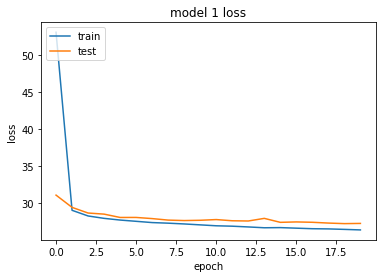

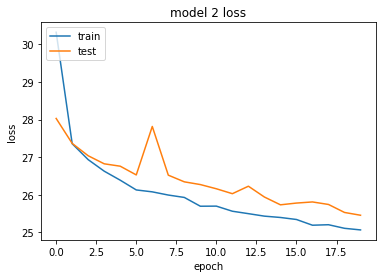

In [26]:
model1.summary()

# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
print("[INFO] predicting house prices...")
predicciones = model2.predict(X_test_mlp)


# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = predicciones - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)


# compute the mean and standard deviation of the absolute percentage difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)


[INFO] predicting house prices...


In [28]:
percentDiff

Price
6418  30.970945
4302 -16.942309
1675   2.219023
1139  18.895054
6885   5.119832
...         ...
6816  -1.654823
8379  12.722799
6565 -25.376555
6635  10.435951
489   -3.606326

[1760 rows x 1 columns]

## **Concatenación de los dos modelos: modelCNN y modelMLP**

In [38]:
from tensorflow.keras.layers import Input
img_shape = (120, 120, 3)
dim_shape = X_train_mlp.shape[1]

# Definimos los dos tipos de input: IMAGEN Y DATA CSV
inputCNN = Input(shape=img_shape, name="image")
inputMLP = Input(shape=dim_shape, name="csv")

In [39]:
# define layers for image data 
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense

x1 = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', name="conv1_img")(inputCNN)
x1 = tf.keras.layers.MaxPooling2D(name="mxp1_img")(x1)
x1 = Dropout(0.2)(x1)
x1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', name="conv2_img")(x1)
x1 = tf.keras.layers.MaxPooling2D(name="mxp2_img")(x1)
x1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', name="conv3_img")(x1)
x1 = Dropout(0.2)(x1)
x1 = tf.keras.layers.MaxPooling2D(name="mxp3_img")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_img")(x1)

In [40]:
# define layers for csv data
x2 = tf.keras.layers.Flatten(name="flatten_csv")(inputMLP)
x2 = tf.keras.layers.Dense(64, activation='relu', name="dense1_csv")(x2)
x2 = tf.keras.layers.Dense(32, activation='relu', name="dense2_csv")(x2)
x2 = tf.keras.layers.Dense(8, activation='relu', name="dense3_csv")(x2)


## Concatenamos los inputs de CNN + MLP

Ahora concatenamos las dos fuentes de datos de entrada: imágenes y datos. 


In [50]:
# merge layers
x = tf.keras.layers.concatenate([x1,x2], name="concat_csv_img")
x = tf.keras.layers.Dense(4, activation='relu', name="dense3_csv_img")(x)
output = tf.keras.layers.Dense(1, activation= 'linear', name="regresion")(x)


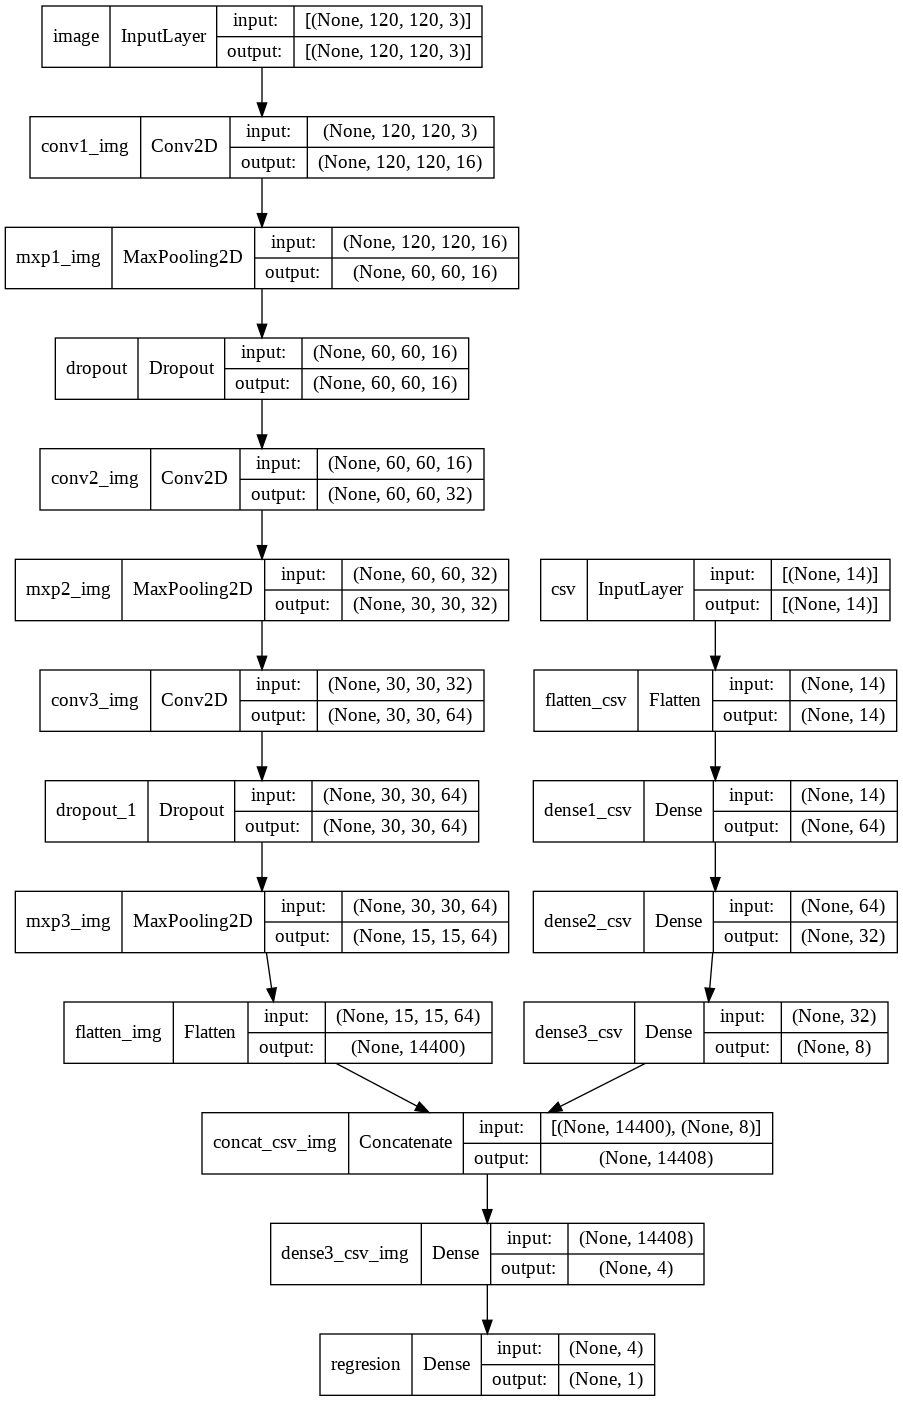

In [51]:
# make model with 2 inputs and 1 output
model = tf.keras.models.Model(inputs=[inputCNN, inputMLP], outputs=output)

model.compile(optimizer='adam',
              loss="mean_absolute_percentage_error",
              metrics=['MAPE'])

from keras.utils.vis_utils import plot_model
plot_model(model,to_file='merged.png',show_shapes=True)

Se entrena solo con 10 épocas por cuestión de tiempo de entreno. Tarda muchísimo, aún trabajando con el entorno de ejecución GPU de google colab. 
El modelo estará underfitted, ya que necesita más épocas para aprender, pero se cumple el objetivo de la práctica de mostrar el procedimiento. 

Intentaría más opciones de arquitectura del modelo, para ver si tiene mejoras, pero lo dicho, tarda demasiado en ejecutar y además cada poco se me elimina el entorno de ejecución por saturación de la RAM y tengo que volver a cargar todo. 

In [52]:
print("[INFO] training model...")
  
history_merged = model.fit(x=[X_train_cnn, X_train_mlp], y=y_train,
	validation_data=([X_test_cnn, X_test_mlp], y_test),
	epochs=10, batch_size=16)

[INFO] training model...
Epoch 1/10
440/440 [==============================] - 5s 9ms/step - loss: 34.9246 - MAPE: 34.9246 - val_loss: 30.3891 - val_MAPE: 30.3891
Epoch 2/10
440/440 [==============================] - 3s 7ms/step - loss: 27.4727 - MAPE: 27.4727 - val_loss: 27.0704 - val_MAPE: 27.0704
Epoch 3/10
440/440 [==============================] - 3s 7ms/step - loss: 27.0644 - MAPE: 27.0644 - val_loss: 26.7231 - val_MAPE: 26.7231
Epoch 4/10
440/440 [==============================] - 3s 8ms/step - loss: 26.6711 - MAPE: 26.6711 - val_loss: 28.4288 - val_MAPE: 28.4288
Epoch 5/10
440/440 [==============================] - 3s 7ms/step - loss: 26.3118 - MAPE: 26.3118 - val_loss: 27.0058 - val_MAPE: 27.0058
Epoch 6/10
440/440 [==============================] - 3s 8ms/step - loss: 26.1468 - MAPE: 26.1468 - val_loss: 25.7211 - val_MAPE: 25.7211
Epoch 7/10
440/440 [==============================] - 3s 7ms/step - loss: 26.1102 - MAPE: 26.1102 - val_loss: 26.5260 - val_MAPE: 26.5260
Epoch 8/1

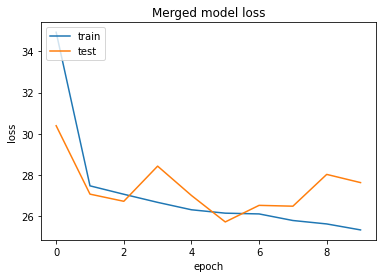

In [53]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history_merged.history['loss'])
plt.plot(history_merged.history['val_loss'])
plt.title('Merged model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
predicted_value = model.predict([X_test_cnn, X_test_mlp])
predicted_value

array([[22.199703],
       [57.83141 ],
       [22.94395 ],
       ...,
       [52.06772 ],
       [77.17113 ],
       [56.30636 ]], dtype=float32)

## Ploteamos las predicciones vs el valor real. 

In [55]:
a = np.amin(predicted_value)
b = np.amin(y_test)
p2 = np.minimum(a,b)
p2
# p2 = np.minimum((np.amin(predicted_value), np.amin(y_test))

Price    7.621524
dtype: float64

In [56]:
c = np.nanmax(predicted_value)
d = np.nanmax(y_test)
p1 = np.maximum(c,d)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


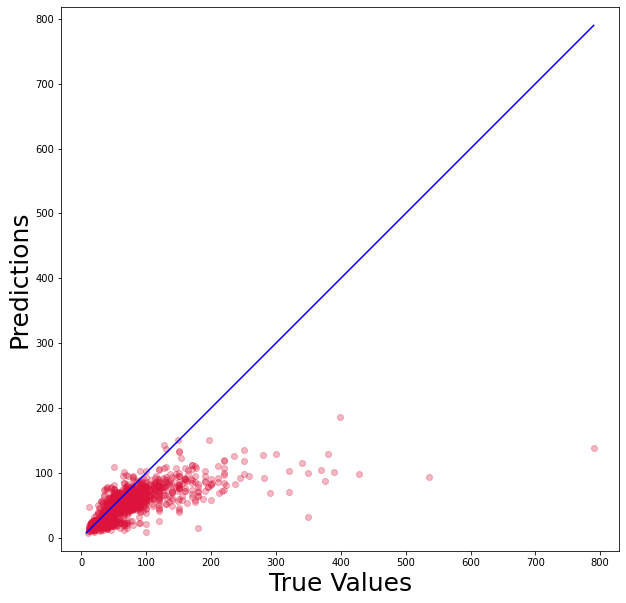

In [57]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, predicted_value, c='crimson', alpha=0.3, )


plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=25)
plt.ylabel('Predictions', fontsize=25)
plt.axis('equal')
plt.show()

# **CONCLUSIÓN: Los resultados de las predicciones son mejores combinando ambos modelos que cada uno por separado**